<a href="https://colab.research.google.com/github/Inna949Festchuk/codespaces-jupyter/blob/main/random_forest_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
This notebook illustrates how to perform Random Forest classification of a Sentinel-2 image using [Remotior Sensus
](https://fromgistors.blogspot.com/p/remotior-sensus.html).

> **Remotior Sensus** *(which is Latin for “a more remote sense”) is a Python package that allows for the processing of remote sensing images and GIS data*.
*Other tutorials are available [here](https://remotior-sensus.readthedocs.io/en/latest/basic_tutorials.html).*



# Install Remotior Sensus and start a new Session

First, we install Remotior Sensus using Pip.

In [1]:
!pip install remotior_sensus

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 334.4/334.4 kB 8.2 MB/s eta 0:00:00



We import Remotior Sensus and **start a Remotior Sensus’** [**session**](https://remotior-sensus.readthedocs.io/en/latest/remotior_sensus.core.session.html), defining the number of processes (`n_processes`) and RAM (`available_ram`) available in the system.

>*For further information about sessions, please read the [User Manual](https://remotior-sensus.readthedocs.io).*

In [2]:
import remotior_sensus
rs = remotior_sensus.Session(n_processes=2, available_ram=10240)

# Prepare Input Data

For the classification we need to:

1. Create a BandSet using an image
2. Load a training input
3. Perform the random forest classification

A [**BandSet**](https://remotior-sensus.readthedocs.io/en/latest/remotior_sensus.core.bandset_catalog.html#remotior_sensus.core.bandset_catalog.BandSet) is an object that includes information about bands (from the file path to the spatial and spectral characteristics).

We can define a working directory where data of this tutorial are saved.

In [3]:
working_directory = '/home'


Before creating the BandSet we should prepare input data.
For the purpose of this tutorial, in order to reduce computation time, we are going to download an already preprocessed Copernicus Sentinel-2 image which includes the following bands.

| Sentinel-2 Bands                    | Central Wavelength  [micrometers]   |  Resolution [meters]   |
|-------------------------------------|-------------------------------------|------------------------|
| Band 2 - Blue                       | 0.490                               |  10                    |
| Band 3 - Green                      |  0.560                              |  10                    |
| Band 4 - Red                        | 0.665                               |  10                    |
| Band 5 - Vegetation Red Edge        | 0.705                               |  20                    |
| Band 6 - Vegetation Red Edge        | 0.740                               |  20                    |
| Band 7 - Vegetation Red Edge        | 0.783                               |  20                    |
| Band 8 - NIR                        | 0.842                               |  10                    |
| Band 8A - Vegetation Red Edge       | 0.865                               |  20                    |
| Band 11 - SWIR                      | 1.610                               |  20                    |
| Band 12 - SWIR                      | 2.190                               |  20                    |


The following code downloads the image subset as a zip file and extracts the bands in the `/home/sample_data`.

> For instructions about how to download satellite data please read [this tutorial](https://remotior-sensus.readthedocs.io/en/latest/tutorial_ndvi.html).

In [4]:
import os
import requests
import zipfile
import shutil

request = requests.get('https://docs.google.com/uc?id=1cWerxZeBY4TJmctKwsvXkfa3No37Pr9a')
file = open(working_directory + '/sample_data.zip', 'wb')
file.write(request.content)
file.close()

os.mkdir(working_directory + '/sample_data')

with zipfile.ZipFile(working_directory + '/sample_data.zip', 'r') as open_file:
  for file_name in open_file.namelist():
    if file_name.endswith('.tif'):
      unzip_file = open_file.open(file_name)
      unzip_t = open(working_directory + '/' + file_name, 'wb')
      with unzip_file, unzip_t:
        shutil.copyfileobj(unzip_file, unzip_t)
      unzip_t.close()

We can display the image.

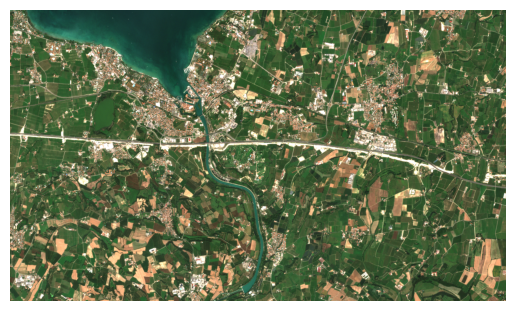

In [5]:
#@title Figure
from osgeo import gdal
import numpy
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

blue = gdal.Open('/home/sample_data/RT_T32TPR_A042919_20230910T101420_B02.tif')
blue_band = blue.GetRasterBand(1).ReadAsArray()
green = gdal.Open('/home/sample_data/RT_T32TPR_A042919_20230910T101420_B03.tif')
green_band = green.GetRasterBand(1).ReadAsArray()
red = gdal.Open('/home/sample_data/RT_T32TPR_A042919_20230910T101420_B04.tif')
red_band = red.GetRasterBand(1).ReadAsArray()
image = numpy.stack((red_band, green_band, blue_band), axis=-1)
image = numpy.clip((image/10000 - 0.1) / 0.2, 0, 1)
plt.imshow(image)
plt.rcParams['figure.figsize'] = (15, 15)
plt.axis('off')
plt.show()
band = image = plt = None

# 1 Create the Input Bandset



Now, we create a [**BandSet Catalog**](https://remotior-sensus.readthedocs.io/en/latest/remotior_sensus.core.bandset_catalog.html) which contains BandSets (note that an empty BandSet 1 will be automatically created).

In [6]:
catalog = rs.bandset_catalog()

Now we create a BandSet using `catalog.create_bandset`:
* `paths` defines the list of paths to the bands, in this case the directory of preprocessed files `[/home/sample_data]` can be used to get all the bands inside this directory
* `bandset_number` explicitly sets the number of the BandSet as 1
* `wavelengths` sets a list of values as the center wavelength for each band, in this case `['Sentinel-2']` automatically defines Sentinel-2 values for the identified bands in the BandSet


We get the first BandSet in the catalog with the function `catalog.get(1)`, then we can print the created BandSet with the BandSet function `print()`.
This is the input that is going to be classified.

In [7]:
catalog.create_bandset(
    paths=['/home/sample_data'],
    bandset_number=1, wavelengths=['Sentinel-2']
    )

catalog.get(1).print()

name: RT_T32TPR_A042919_20230910T101420_B 
date: NaT 
root directory: None 
crs: PROJCS["WGS 84 / UTM zone 32N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",9],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32632"]] 
┌─────────────┬─────────────┬─────────────────────────────────────────────────────────────┬────────────────┬───────────────────────────────────────┬────────────┬─────────────────┬─────────────────┬───────────────────────┬──────┬────────┬────────┬───────────┬──────────┬───────────┬──────────┬─────────┬─────────┬────────┬

# 2 Load the Training Input

In general, we would need to create a vector file containing polygons (ROIs) used to train the algorithm, where each polygon corresponds to a class (or macroclass).

In this tutorial, the following macroclasses are considered.


|   Macroclass name   |   Macroclass ID   |
|---------------------|-------------------|
|   Water             |   1               |
|   Built-up          |   2               |
|   Vegetation        |   3               |
|   Soil              |   4               |

For the creation of these polygons, one can use GIS software such as the [Semi-Automatic Classification Plugin](https://semiautomaticclassificationmanual.readthedocs.io) for QGIS.
For the purpose of this tutorial, we are going to download an already prepared geopackage of polygons.

> More information about **classes and macroclasses** is available [here](https://semiautomaticclassificationmanual.readthedocs.io/it/latest/remote_sensing.html#classes-and-macroclasses).


In [8]:
request = requests.get('https://docs.google.com/uc?id=1onFqHdk1aTN9WYb6ZoUnAkZMiZEUoITd')

file = open(working_directory + '/training.gpkg', 'wb')
file.write(request.content)
file.close()

To open the training input, first we create a **Spectral Signatures Catalog** using [**SpectralSignaturesCatalog**](https://remotior-sensus.readthedocs.io/en/latest/remotior_sensus.core.spectral_signatures.html#remotior_sensus.core.spectral_signatures.SpectralSignaturesCatalog), which must be created specifically for a BandSet (and the characteristics thereof):


* `bandset` sets the reference BandSet



In [9]:
bandset_1 = catalog.get(1)

signature_catalog = rs.spectral_signatures_catalog(
    bandset=bandset_1
    )

Now we can import the geopackage in the Spectral Signatures Catalog using the function `import_vector`:
* `file_path` sets the path of the input file, in this case `working_directory + '/training.gpkg'`
* `macroclass_field` sets the name of the field corresponding to the macroclass ID in the vector
* `macroclass_name_field` sets the name of the field corresponding to the macroclass name in the vector
* `class_field` sets the name of the field corresponding to the class ID in the vector
* `class_name_field` sets the name of the field corresponding to the class name in the vector

In [10]:
signature_catalog.import_vector(
    file_path=working_directory + '/training.gpkg',
    macroclass_field='macroclass_id',
    macroclass_name_field='macroclass_name',
    class_field='class_id',
    class_name_field='class_name'
    )

 remotior_sensus [ 57%] calculate signature ⚙

# 3 Perform Random Forest Classification

We are going to train the **Random Forest** classifier and perform the classification.

To classify the image we are going to use the tool [**band_classification**](https://remotior-sensus.readthedocs.io/en/latest/remotior_sensus.tools.band_classification.html#remotior_sensus.tools.band_classification.band_classification), with the following parameters:
* `input_bands` is a parameter that accepts a list of input raster paths, or a BandSet number, or a previously defined BandSet
* `bandset_catalog` the catalog containing the BandSet (in case `input_bands` is a BandSet number)
* `spectral_signatures` the SpectralSignaturesCatalog containing the training input
* `macroclass` if True, the training in evaluated on the macroclass ID field; if False, the training is evaluated on the class ID field
* `output_path` sets the output path of the classification raster
* `save_classifier` is an optional parameter, if True saves the classifier to a file to be loaded (without training) for a new classification
* `classification_confidence` is an optional parameter, if True, writes a classification confidence raster as additional output, useful to evaluate the confidence of the classifier at pixel level (from 0=low to 1=high confidence)
* `algorithm_name` is the name of the classification algorithms, which for Random Forest is `'rf'`, other options are:
  * Minimum Distance = 'md'
  * Maximum Likelihood = 'ml'
  * Spectral Angle Mapping = 'sam'
  * Random Forest OneVsRest = 'rf_ovr'
  * Support Vector Machine = 'svm'
  * Multi Layer Perceptron = 'mlp'
  * Multi Layer Perceptron using PyTorch framework = 'pytorch_mlp'


Available parameters for **Random Forest** are:
* `rf_max_features` parameter that sets the number of features considered in node splitting; if None all features are considered in node splitting, available options are ‘sqrt’ as square root of all the features, an integer number, or a float number for a fraction of all the features.
* `rf_number_trees` parameter that sets the number of trees in the forest
* `rf_min_samples_split` parameter that sets the minimum number of samples required to split an internal node

In [11]:
classification = rs.band_classification(
    input_bands=1,
    bandset_catalog=catalog,
    spectral_signatures=signature_catalog,
    macroclass=True,
    output_path=working_directory + '/classification_rf.tif',
    classification_confidence=True,
    algorithm_name='rf',
    rf_number_trees=500,
    rf_min_samples_split=2
    )

 band classification [ 20%] [elapsed 2min09sec] [remaining 6min28sec]:fitting ⬤

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 500
building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500


[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.8s


building tree 43 of 500
building tree 44 of 500
building tree 45 of 500
building tree 46 of 500
building tree 47 of 500
building tree 48 of 500
building tree 49 of 500
building tree 50 of 500
building tree 51 of 500
building tree 52 of 500
building tree 53 of 500
building tree 54 of 500
building tree 55 of 500
building tree 56 of 500
building tree 57 of 500
building tree 58 of 500
building tree 59 of 500
building tree 60 of 500
building tree 61 of 500
building tree 62 of 500
building tree 63 of 500
building tree 64 of 500
building tree 65 of 500
building tree 66 of 500
building tree 67 of 500
building tree 68 of 500
building tree 69 of 500
building tree 70 of 500
building tree 71 of 500
building tree 72 of 500
building tree 73 of 500
building tree 74 of 500
building tree 75 of 500
building tree 76 of 500
building tree 77 of 500
building tree 78 of 500
building tree 79 of 500
building tree 80 of 500
building tree 81 of 500
building tree 82 of 500
building tree 83 of 500
building tree 84

[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:    9.2s


building tree 161 of 500
building tree 162 of 500
building tree 163 of 500
building tree 164 of 500
building tree 165 of 500
building tree 166 of 500
building tree 167 of 500
building tree 168 of 500
building tree 169 of 500
building tree 170 of 500
building tree 171 of 500
building tree 172 of 500
building tree 173 of 500
building tree 174 of 500
building tree 175 of 500
building tree 176 of 500
building tree 177 of 500
building tree 178 of 500
building tree 179 of 500
building tree 180 of 500
building tree 181 of 500
building tree 182 of 500
building tree 183 of 500
building tree 184 of 500
building tree 185 of 500
building tree 186 of 500
building tree 187 of 500
building tree 188 of 500
building tree 189 of 500
building tree 190 of 500
building tree 191 of 500
building tree 192 of 500
building tree 193 of 500
building tree 194 of 500
building tree 195 of 500
building tree 196 of 500
building tree 197 of 500
building tree 198 of 500
building tree 199 of 500
building tree 200 of 500


[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed:   21.1s


building tree 367 of 500
building tree 368 of 500
building tree 369 of 500
building tree 370 of 500
building tree 371 of 500
building tree 372 of 500
building tree 373 of 500
building tree 374 of 500
building tree 375 of 500building tree 376 of 500

building tree 377 of 500
building tree 378 of 500
building tree 379 of 500
building tree 380 of 500
building tree 381 of 500
building tree 382 of 500
building tree 383 of 500
building tree 384 of 500
building tree 385 of 500
building tree 386 of 500
building tree 387 of 500
building tree 388 of 500
building tree 389 of 500
building tree 390 of 500
building tree 391 of 500
building tree 392 of 500
building tree 393 of 500
building tree 394 of 500
building tree 395 of 500
building tree 396 of 500
building tree 397 of 500
building tree 398 of 500
building tree 399 of 500
building tree 400 of 500
building tree 401 of 500
building tree 402 of 500
building tree 403 of 500
building tree 404 of 500
building tree 405 of 500
building tree 406 of 500


[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:   29.7s finished


 band classification [ 81%] [elapsed 3min01sec] [remaining 0min42sec] writing raster ⚙

We can display the resulting classification raster.

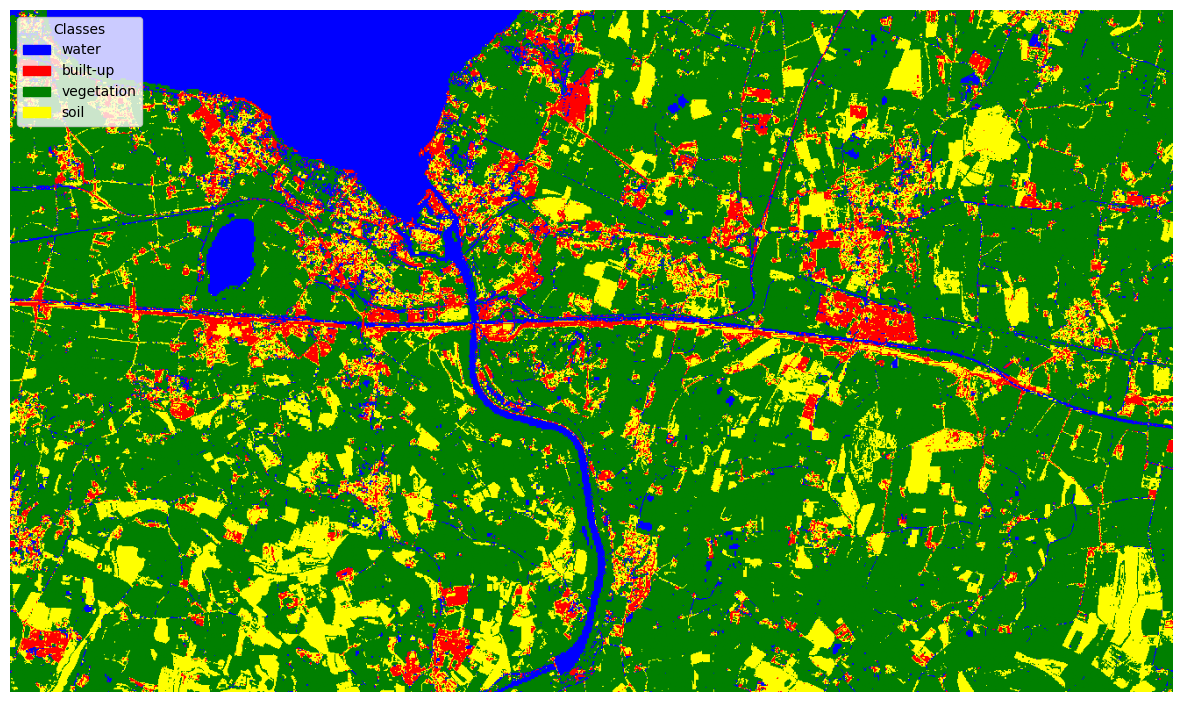

In [12]:
#@title Figure
from osgeo import gdal
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

image = gdal.Open(classification.path)
band = image.GetRasterBand(1).ReadAsArray()
color_map = mcolors.ListedColormap(['blue', 'red', 'green', 'yellow'])
plt.imshow(band, cmap=color_map, vmin=1, vmax=4)
plt.rcParams['figure.figsize'] = (15, 15)
plt.axis('off')
legend_handles = [mpatches.Patch(color=c, label=str(val)) for val, c in zip(['water', 'built-up', 'vegetation', 'soil'], ['blue', 'red', 'green', 'yellow'])]
plt.legend(handles=legend_handles, title='Classes', bbox_to_anchor=(0, 1), loc='upper left')
plt.show()
band = image = plt = None

We can also display the **confidence raster** of the classification, which is a raster having values ranging from 0 (low confidence) to 1 (high confidence).

We can use this confidence raster to assess the quality of the classification and collect additional training areas to improve the results.

In [ ]:
#@title Figure
from osgeo import gdal
import numpy
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

image = gdal.Open(classification.extra['algorithm_raster'])
band = image.GetRasterBand(1).ReadAsArray()
plt.imshow(band, cmap='viridis', vmin=0, vmax=1)
plt.rcParams['figure.figsize'] = (15, 15)
plt.axis('off')

color_values = numpy.linspace(0, 1, 5)
color_map = plt.cm.viridis
legend_handles = []
for v in color_values:
    legend_handles.append(mpatches.Patch(color=color_map(v), label=str(v)))
plt.legend(handles=legend_handles, title='Confidence', bbox_to_anchor=(0, 1), loc='upper left')

plt.show()
band = image = plt = None

# Close the Session
The session should be closed at the end of all the processes to **remove the temporary files and stop subprocesses**.

In [ ]:
rs.close()